In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
import glob
import pylustrator

print(plt.style.available)
plt.style.use('seaborn-v0_8-talk')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 14


['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [2]:
def set_high_dpi():
    plt.rcParams['figure.dpi'] = 400
    # plt.rcParams['figure.figsize'] = [8, 6]
    plt.rcParams['savefig.dpi'] = 400
    plt.rcParams['savefig.format'] = 'png'
    plt.rcParams['savefig.transparent'] = True

In [3]:
set_high_dpi()

In [4]:
LOG_PATH = "../logs/overhead/"
NU_SOCIALNET_LOG_PATH = LOG_PATH + "nu_socialnet/"

In [5]:
from dataclasses import dataclass
@dataclass
class Metric:
    label: str


In [6]:
data = []

In [7]:
def extract_data(match: str, embed: bool, debugger: str):
    # from 1 server to 7 servers setup
    for i in range(1, 8):
        files = glob.glob(NU_SOCIALNET_LOG_PATH + f"{match}.{i}.*")
        mops = 0
        avg_lat_sum = 0
        lat_p50_sum = 0
        lat_p90_sum = 0
        lat_p95_sum = 0
        lat_p99_sum = 0
        for file in files:
            with open(file, 'r') as f:
                lines = f.readlines()
                if lines:
                    # print(lines[-1].strip())
                    line_d = lines[-1].strip().split()
                    mops += float(line_d[0])
                    avg_lat_sum += int(line_d[1])
                    lat_p50_sum += int(line_d[2])
                    lat_p90_sum += int(line_d[3])
                    lat_p95_sum += int(line_d[4])
                    lat_p99_sum += int(line_d[5])
        avg_lat = avg_lat_sum / len(files)
        lat_p50 = lat_p50_sum / len(files)
        lat_p90 = lat_p90_sum / len(files)
        lat_p95 = lat_p95_sum / len(files)
        lat_p99 = lat_p99_sum / len(files)
        # print(f"i: {i}, mops: {mops}")
        data.append(
            {
                "servers": i,
                "mops": mops,
                "avg_lat": avg_lat,
                "lat_p50": lat_p50,
                "lat_p90": lat_p90,
                "lat_p95": lat_p95,
                "lat_p99": lat_p99,
                "embed": embed,
                "debugger": debugger
            }
        )

In [8]:
extract_data("DDB_DISABLE", False, "none")
extract_data("DDB_ENABLE", True, "none")
extract_data("gdb.DDB_DISABLE", False, "gdb")
extract_data("ddb.DDB_ENABLE", True, "ddb")

In [9]:
df = pd.DataFrame(data)
df.head()

,servers,mops,avg_lat,lat_p50,lat_p90,lat_p95,lat_p99,embed,debugger
0,1,0.683483,775.333333,103.666667,466.000000,906.000000,19228.666667,False,none
1,2,0.982959,605.333333,248.333333,871.000000,1396.666667,9300.666667,False,none
2,3,1.330125,446.666667,200.666667,650.000000,1028.333333,6496.000000,False,none
3,4,1.665112,358.000000,184.333333,599.666667,966.666667,4255.333333,False,none
4,5,1.958418,305.333333,192.000000,650.333333,992.000000,1943.666667,False,none


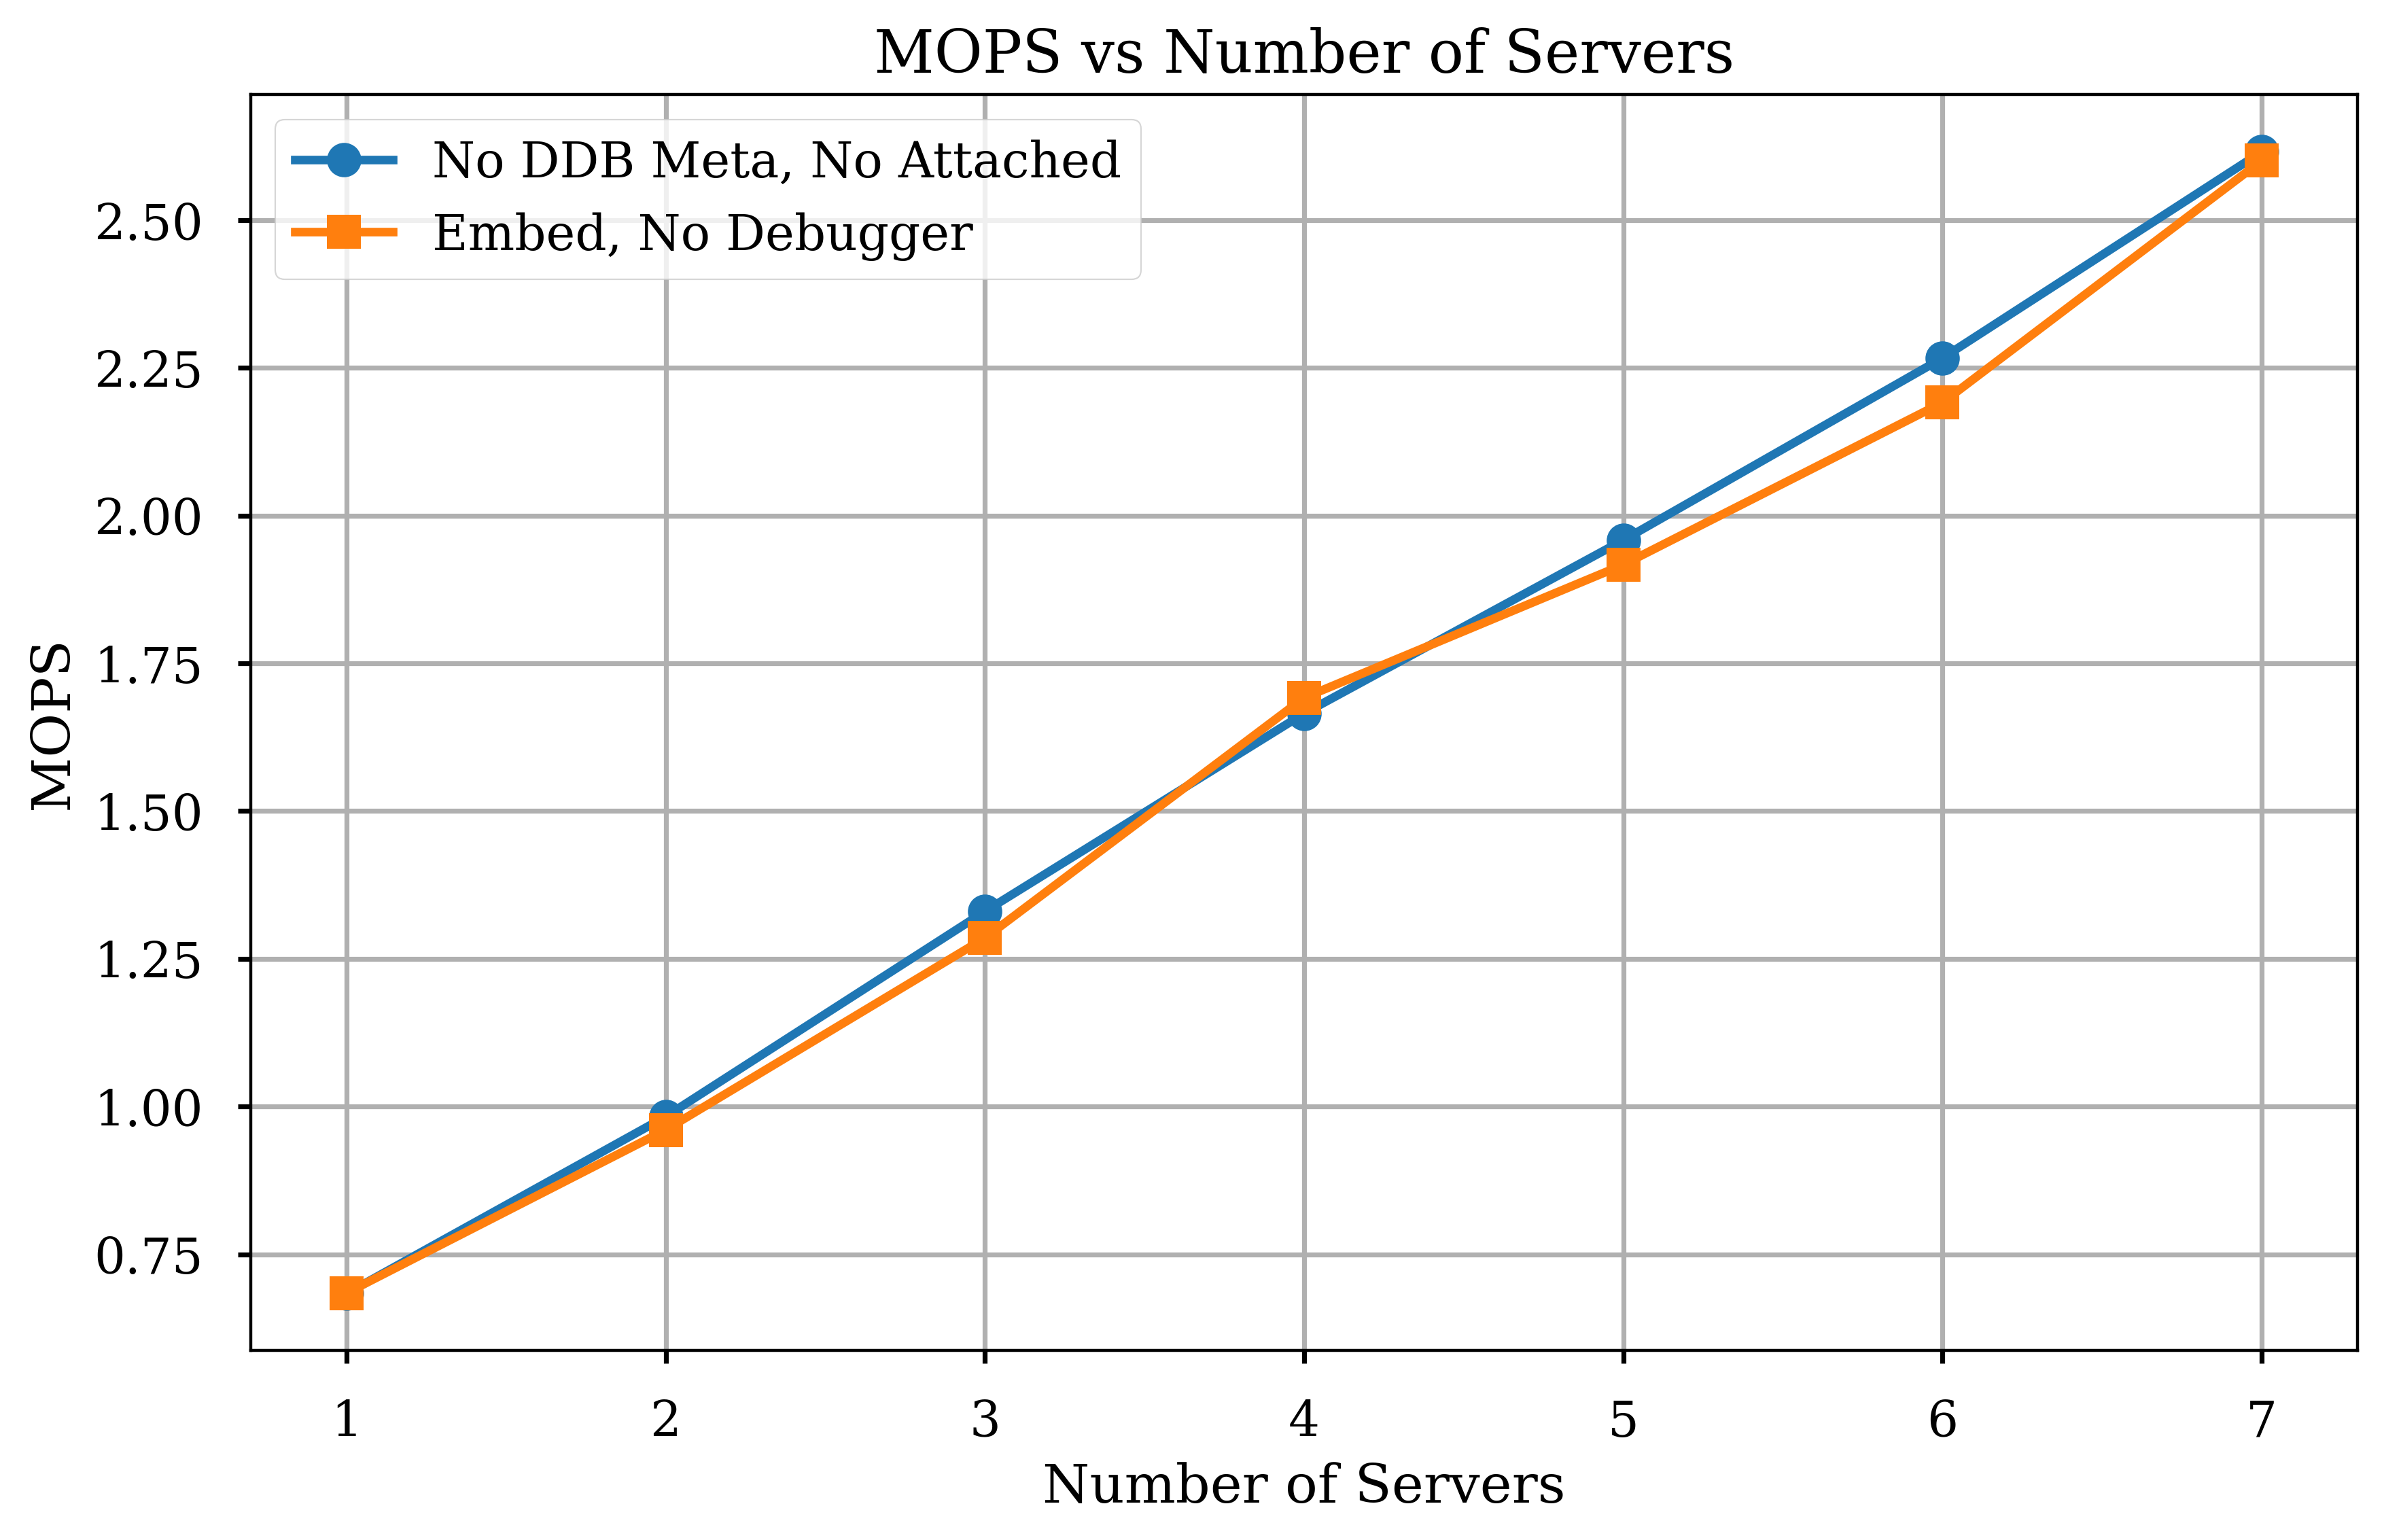

In [10]:
# plt.style.use('fivethirtyeight')
# plt.style.use('default')

plt.figure(figsize=(10, 6))
# plt.figure(figsize=(12, 6))

# Plot for embed == False and debugger == "none"
filtered_df = df.query('embed == False and debugger == "none"')
plt.plot(filtered_df['servers'], filtered_df['mops'], label='No DDB Meta, No Attached', marker='o')
# plt.scatter(filtered_df['servers'], filtered_df['mops'], marker='o')

# filtered_df = df.query('embed == False and debugger == "gdb"')
# plt.plot(filtered_df['servers'], filtered_df['mops'], label='No DDB Meta, GDB Attached', marker='^')

# Plot for embed == True and debugger == "none"
filtered_df = df.query('embed == True and debugger == "none"')
plt.plot(filtered_df['servers'], filtered_df['mops'], label='Embed, No Debugger', marker='s')
# plt.scatter(filtered_df['servers'], filtered_df['mops'], marker='s')


# filtered_df = df.query('embed == True and debugger == "ddb"')
# plt.plot(filtered_df['servers'], filtered_df['mops'], label='Embed, DDB Debugger', marker='d')


plt.xlabel('Number of Servers')
plt.ylabel('MOPS')
plt.title('MOPS vs Number of Servers')
plt.legend()
plt.grid(True)
plt.show()

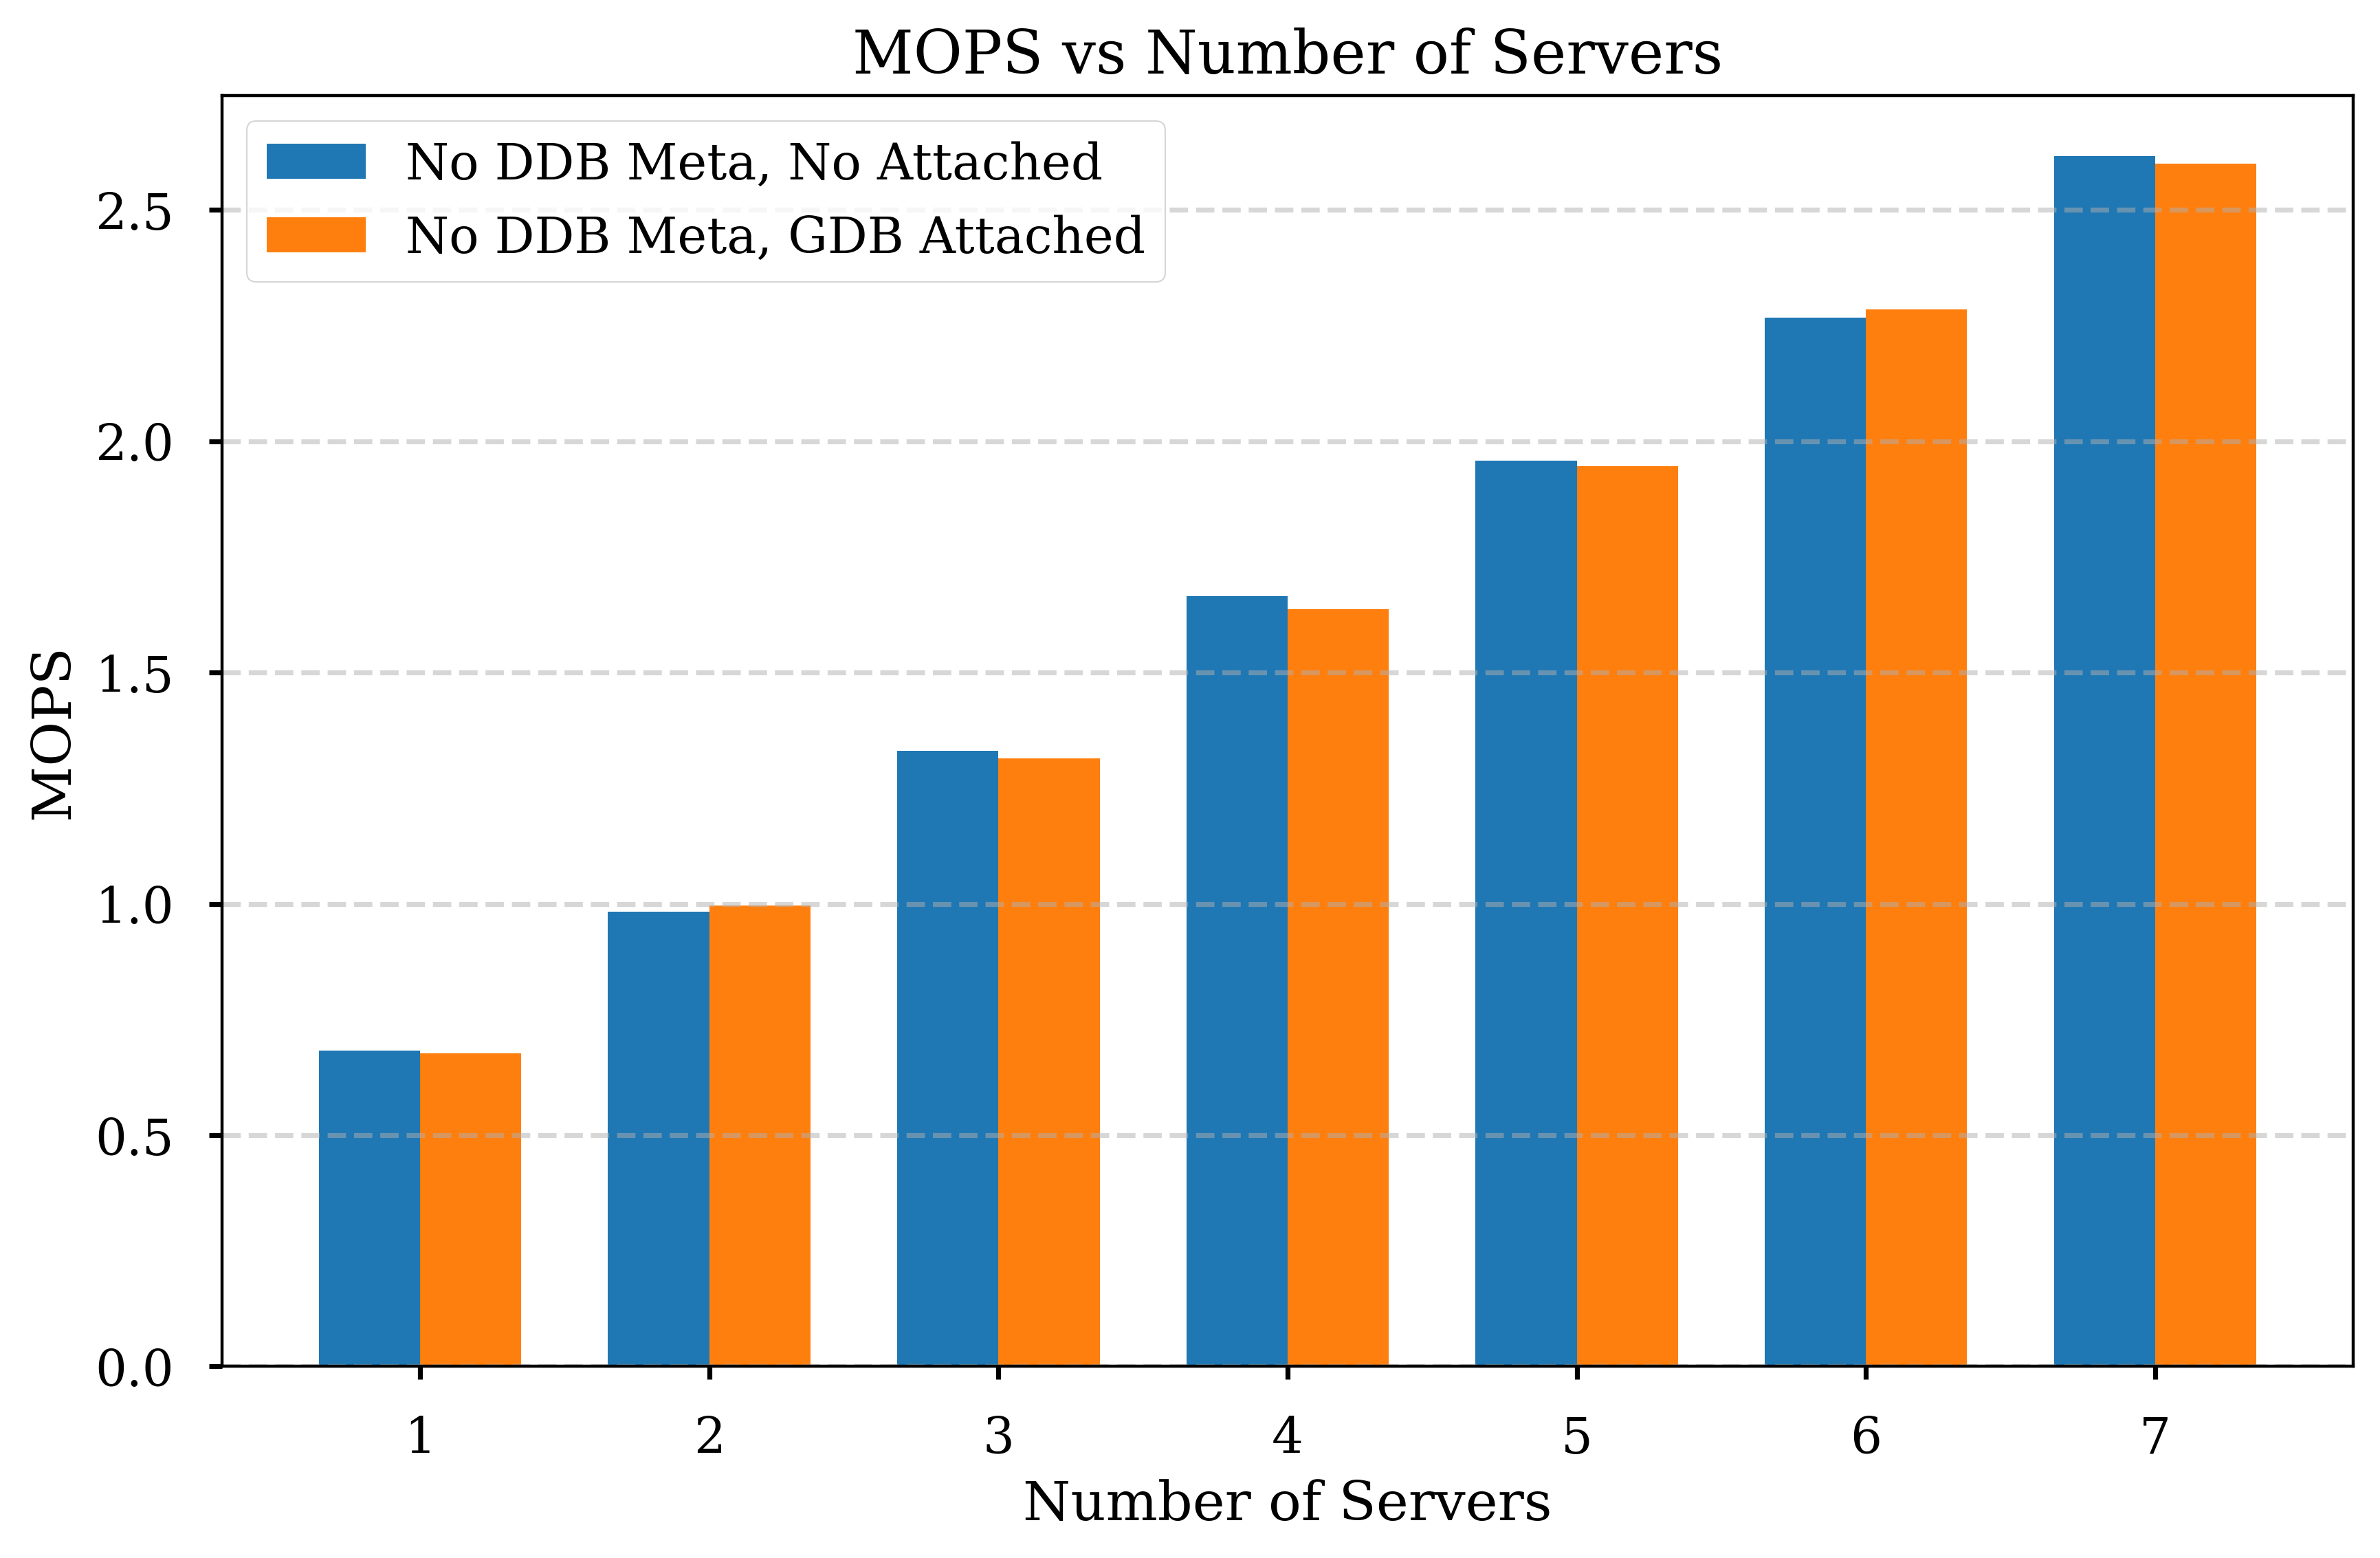

In [11]:
plt.figure(figsize=(10, 6))

# Define the width of the bars
bar_width = 0.35

# Plot for embed == False and debugger == "none"
filtered_df_none = df.query('embed == False and debugger == "none"')
plt.bar(filtered_df_none['servers'] - bar_width/2, filtered_df_none['mops'], width=bar_width, label='No DDB Meta, No Attached')

# Plot for embed == False and debugger == "gdb"
filtered_df_gdb = df.query('embed == False and debugger == "gdb"')
plt.bar(filtered_df_gdb['servers'] + bar_width/2, filtered_df_gdb['mops'], width=bar_width, label='No DDB Meta, GDB Attached')

plt.xlabel('Number of Servers')
plt.ylabel('MOPS')
plt.title('MOPS vs Number of Servers')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
# plt.grid(False)
plt.show()


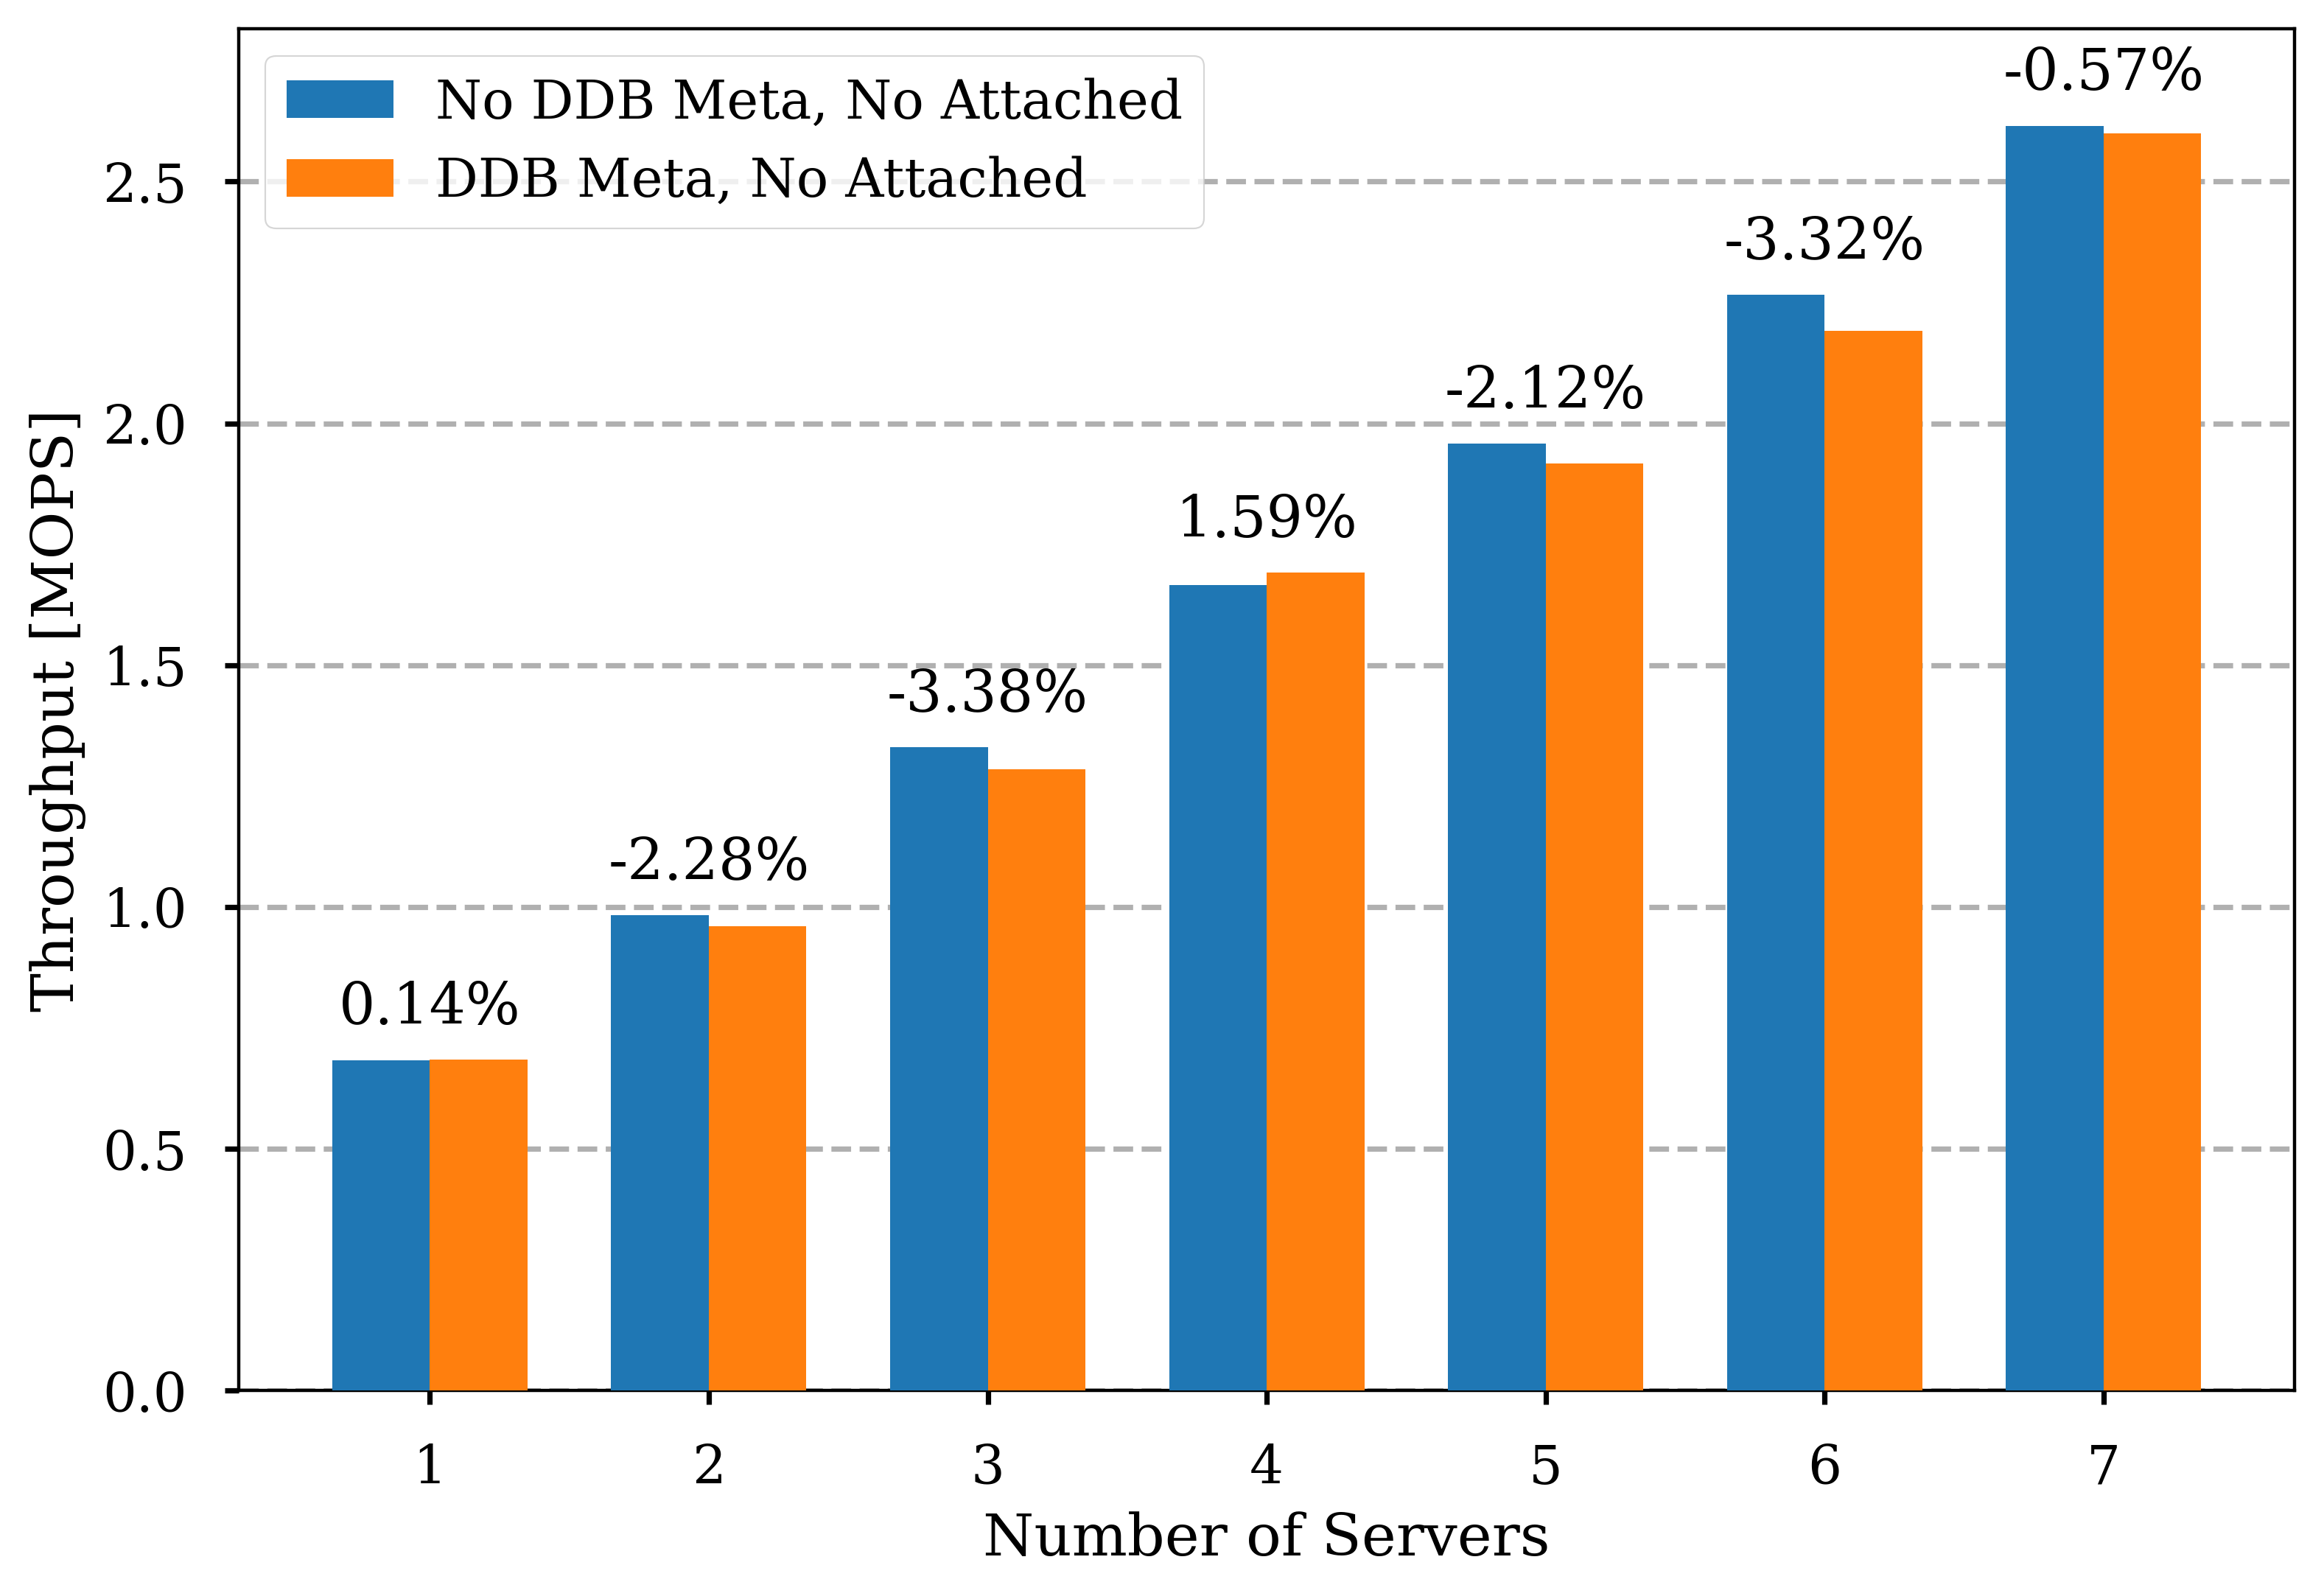

In [12]:
plt.figure(figsize=(9, 6))

# Define the width of the bars
bar_width = 0.35

# Plot for embed == False and debugger == "none"
filtered_df_none = df.query('embed == False and debugger == "none"')
bars1 = plt.bar(filtered_df_none['servers'] - bar_width/2, filtered_df_none['mops'], width=bar_width, label='No DDB Meta, No Attached', zorder=3)

# Plot for embed == True and debugger == "none"
filtered_df_gdb = df.query('embed == True and debugger == "none"')
bars2 = plt.bar(filtered_df_gdb['servers'] + bar_width/2, filtered_df_gdb['mops'], width=bar_width, label='DDB Meta, No Attached', zorder=3)

# Calculate the percentage difference and annotate
for i in range(len(filtered_df_none)):
    server = filtered_df_none['servers'].iloc[i]
    mops_none = filtered_df_none['mops'].iloc[i]
    mops_gdb = filtered_df_gdb[filtered_df_gdb['servers'] == server]['mops'].values[0]
    percentage_diff = ((mops_gdb - mops_none) / mops_none) * 100
    plt.text(server, max(mops_none, mops_gdb) + 0.05, f'{percentage_diff:.2f}%', ha='center', va='bottom', zorder=4)

plt.xlabel('Number of Servers')
plt.ylabel('Throughput [MOPS]')
# plt.title('MOPS vs Number of Servers')
plt.legend()
plt.grid(axis='y', linestyle='--', zorder=0)

# Increase the y-limit
plt.ylim(0, df['mops'].max() + 0.2)

plt.show()

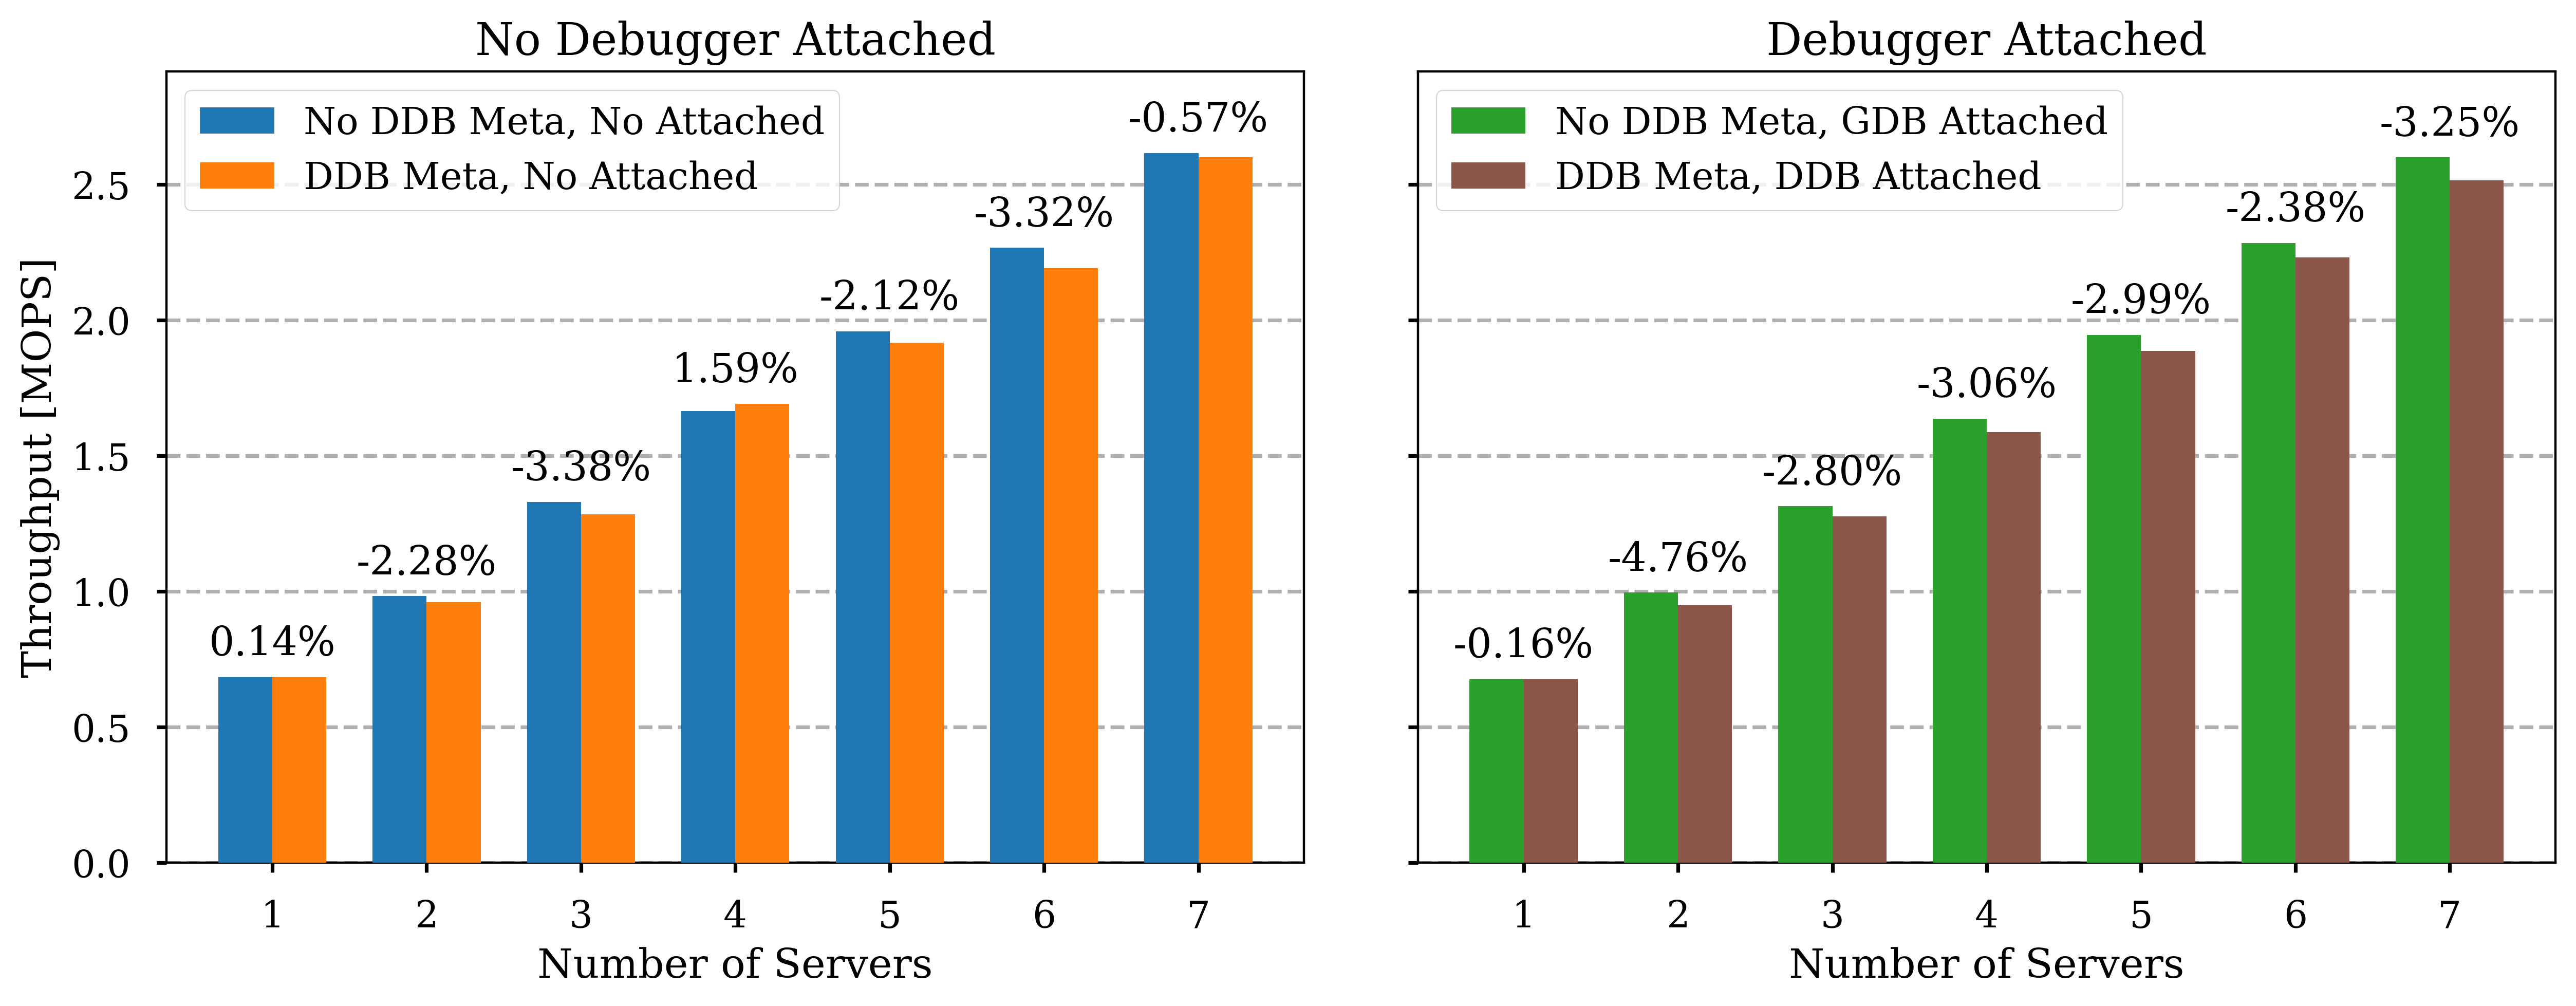

In [13]:
# Create a new subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

# Adjust the space between subplots
plt.subplots_adjust(wspace=0.1)

# Plot for embed == False and debugger == "none"
filtered_df_none = df.query('embed == False and debugger == "none"')
bars1 = ax1.bar(filtered_df_none['servers'] - bar_width/2, filtered_df_none['mops'], width=bar_width, label='No DDB Meta, No Attached', zorder=3)

# Plot for embed == True and debugger == "none"
filtered_df_gdb = df.query('embed == True and debugger == "none"')
bars2 = ax1.bar(filtered_df_gdb['servers'] + bar_width/2, filtered_df_gdb['mops'], width=bar_width, label='DDB Meta, No Attached', zorder=3)

# Calculate the percentage difference and annotate
for i in range(len(filtered_df_none)):
    server = filtered_df_none['servers'].iloc[i]
    mops_none = filtered_df_none['mops'].iloc[i]
    mops_gdb = filtered_df_gdb[filtered_df_gdb['servers'] == server]['mops'].values[0]
    percentage_diff = ((mops_gdb - mops_none) / mops_none) * 100
    ax1.text(server, max(mops_none, mops_gdb) + 0.05, f'{percentage_diff:.2f}%', ha='center', va='bottom', zorder=4)

ax1.set_xlabel('Number of Servers')
ax1.set_ylabel('Throughput [MOPS]')
ax1.set_title('No Debugger Attached')
ax1.legend()
ax1.grid(axis='y', linestyle='--', zorder=0)
ax1.set_ylim(0, df['mops'].max() + 0.3)

# Plot for embed == False and debugger == "gdb"
filtered_df_gdb = df.query('embed == False and debugger == "gdb"')
bars3 = ax2.bar(filtered_df_gdb['servers'] - bar_width/2, filtered_df_gdb['mops'], width=bar_width, label='No DDB Meta, GDB Attached', zorder=3, color='tab:green')

# Plot for embed == True and debugger == "ddb"
filtered_df_ddb = df.query('embed == True and debugger == "ddb"')
bars4 = ax2.bar(filtered_df_ddb['servers'] + bar_width/2, filtered_df_ddb['mops'], width=bar_width, label='DDB Meta, DDB Attached', zorder=3, color='tab:brown')

# Calculate the percentage difference and annotate
for i in range(len(filtered_df_gdb)):
    server = filtered_df_gdb['servers'].iloc[i]
    mops_gdb = filtered_df_gdb['mops'].iloc[i]
    mops_ddb = filtered_df_ddb[filtered_df_ddb['servers'] == server]['mops'].values[0]
    percentage_diff = ((mops_ddb - mops_gdb) / mops_gdb) * 100
    ax2.text(server, max(mops_gdb, mops_ddb) + 0.05, f'{percentage_diff:.2f}%', ha='center', va='bottom', zorder=4)

ax2.set_xlabel('Number of Servers')
ax2.set_title('Debugger Attached')
ax2.legend()
ax2.grid(axis='y', linestyle='--', zorder=0)

# plt.suptitle('MOPS vs Number of Servers')
plt.show()

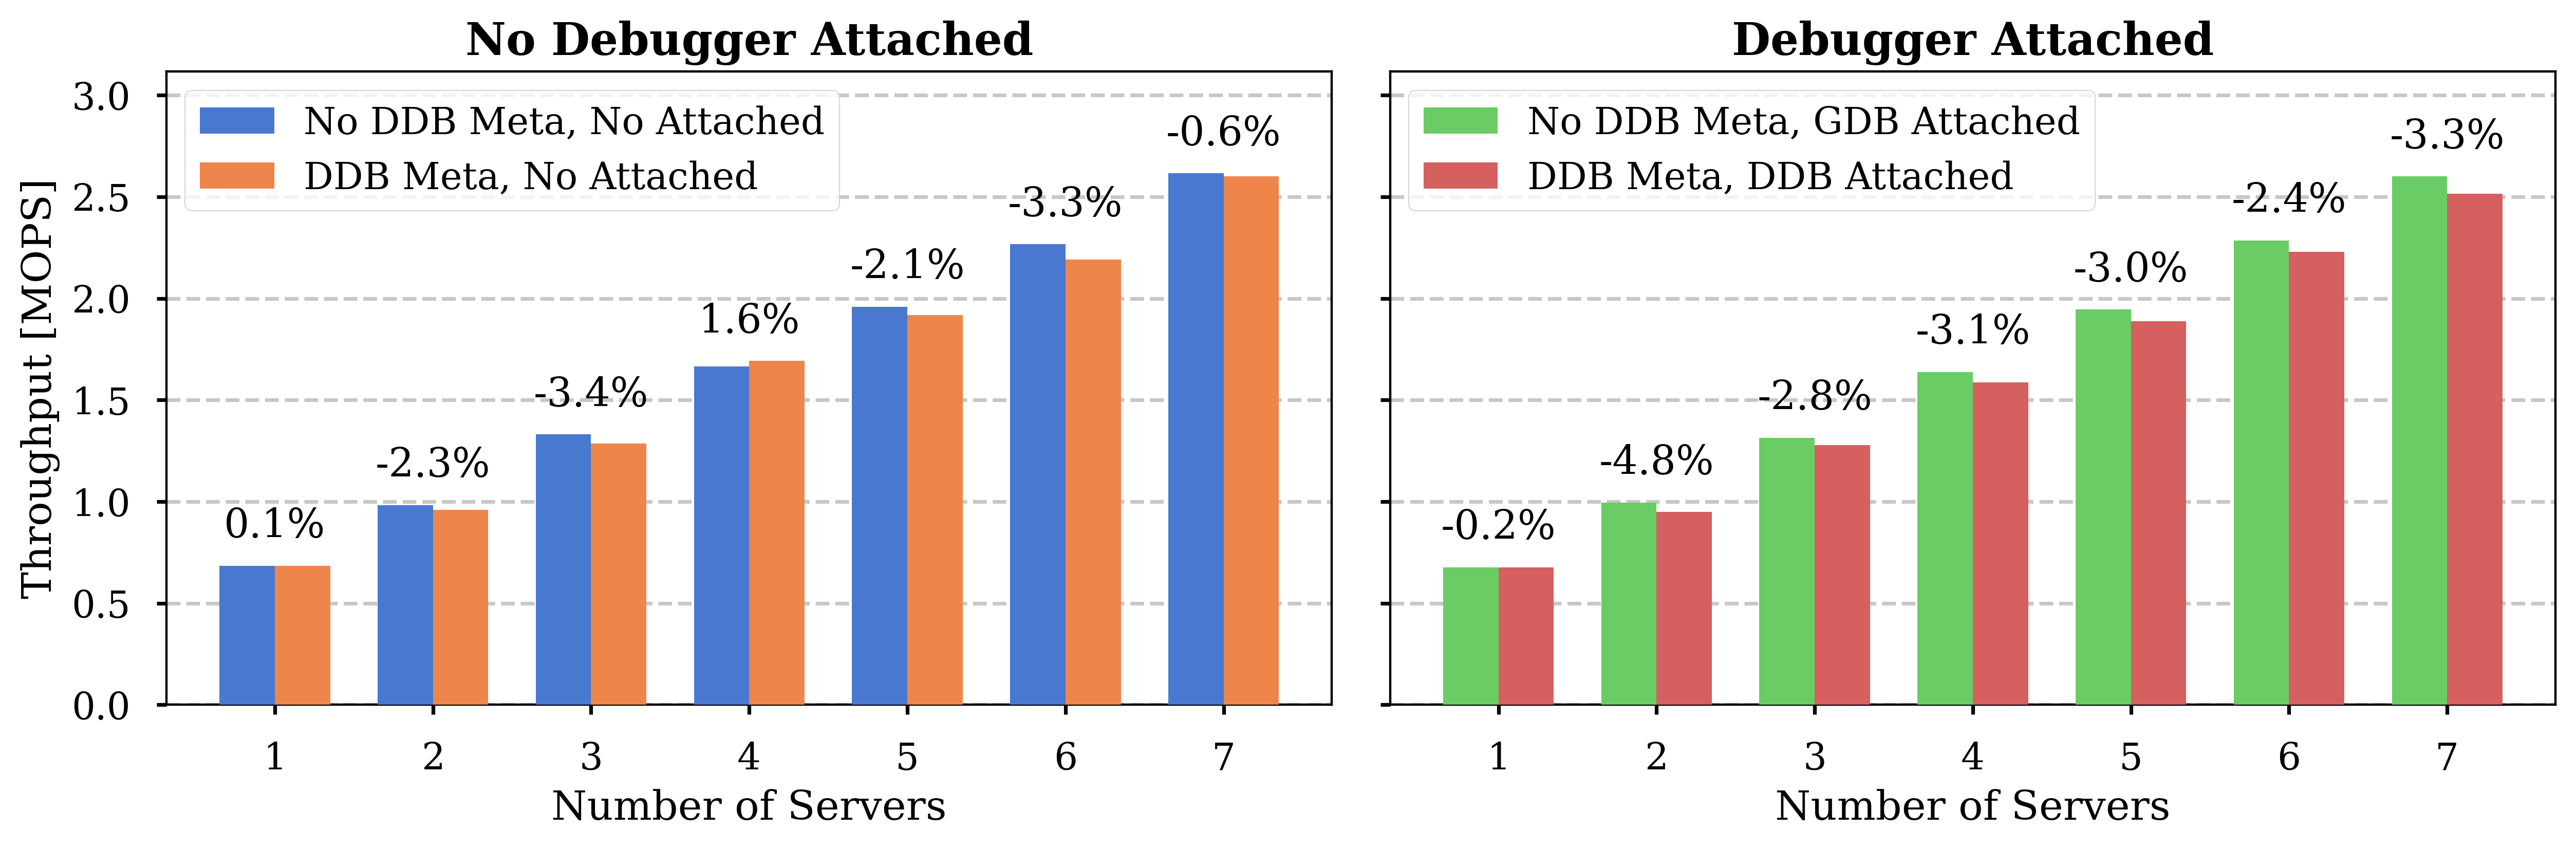

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a new subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4), sharey=True)

# Adjust the space between subplots
plt.subplots_adjust(wspace=0.05)

# # Muted colors for the bars
# colors = {
#     'no_meta_no_attached': '#1f77b4',  # muted blue
#     'ddb_meta_no_attached': '#ff7f0e',  # muted orange
#     'no_meta_gdb_attached': '#2ca02c',  # muted green
#     'ddb_meta_attached': '#d62728',  # muted red
# }
palette = sns.color_palette("muted")
colors = {
    'no_meta_no_attached': palette[0],
    'ddb_meta_no_attached': palette[1],
    'no_meta_gdb_attached': palette[2],
    'ddb_meta_attached': palette[3],
}


# Plot for embed == False and debugger == "none"
filtered_df_none = df.query('embed == False and debugger == "none"')
bars1 = ax1.bar(
    filtered_df_none['servers'] - bar_width / 2,
    filtered_df_none['mops'],
    width=bar_width,
    label='No DDB Meta, No Attached',
    zorder=3,
    color=colors['no_meta_no_attached']
)

# Plot for embed == True and debugger == "none"
filtered_df_gdb = df.query('embed == True and debugger == "none"')
bars2 = ax1.bar(
    filtered_df_gdb['servers'] + bar_width / 2,
    filtered_df_gdb['mops'],
    width=bar_width,
    label='DDB Meta, No Attached',
    zorder=3,
    color=colors['ddb_meta_no_attached']
)

# Annotate percentage difference
for i in range(len(filtered_df_none)):
    server = filtered_df_none['servers'].iloc[i]
    mops_none = filtered_df_none['mops'].iloc[i]
    mops_gdb = filtered_df_gdb[filtered_df_gdb['servers'] == server]['mops'].values[0]
    percentage_diff = ((mops_gdb - mops_none) / mops_none) * 100
    ax1.text(
        server,
        max(mops_none, mops_gdb) + 0.1,
        f'{percentage_diff:.1f}%',
        ha='center',
        va='bottom',
        color='black'
    )

# Configure ax1
ax1.set_xlabel('Number of Servers')
ax1.set_ylabel('Throughput [MOPS]')
ax1.set_title('No Debugger Attached', fontweight='bold')
ax1.legend()
ax1.grid(axis='y', linestyle='--', alpha=0.7, zorder=0)
ax1.set_ylim(0, df['mops'].max() + 0.5)

# Plot for embed == False and debugger == "gdb"
filtered_df_gdb = df.query('embed == False and debugger == "gdb"')
bars3 = ax2.bar(
    filtered_df_gdb['servers'] - bar_width / 2,
    filtered_df_gdb['mops'],
    width=bar_width,
    label='No DDB Meta, GDB Attached',
    zorder=3,
    color=colors['no_meta_gdb_attached']
)

# Plot for embed == True and debugger == "ddb"
filtered_df_ddb = df.query('embed == True and debugger == "ddb"')
bars4 = ax2.bar(
    filtered_df_ddb['servers'] + bar_width / 2,
    filtered_df_ddb['mops'],
    width=bar_width,
    label='DDB Meta, DDB Attached',
    zorder=3,
    color=colors['ddb_meta_attached']
)

# Annotate percentage difference
for i in range(len(filtered_df_gdb)):
    server = filtered_df_gdb['servers'].iloc[i]
    mops_gdb = filtered_df_gdb['mops'].iloc[i]
    mops_ddb = filtered_df_ddb[filtered_df_ddb['servers'] == server]['mops'].values[0]
    percentage_diff = ((mops_ddb - mops_gdb) / mops_gdb) * 100
    ax2.text(
        server,
        max(mops_gdb, mops_ddb) + 0.1,
        f'{percentage_diff:.1f}%',
        ha='center',
        va='bottom',
        color='black'
    )

# Configure ax2
ax2.set_xlabel('Number of Servers')
ax2.set_title('Debugger Attached', fontweight='bold')
ax2.legend()
ax2.grid(axis='y', linestyle='--', alpha=0.7, zorder=0)

# Add a shared title and show the plot
# fig.suptitle('MOPS vs Number of Servers: Impact of Debugging Configuration', fontsize=16, fontweight='bold')
plt.show()


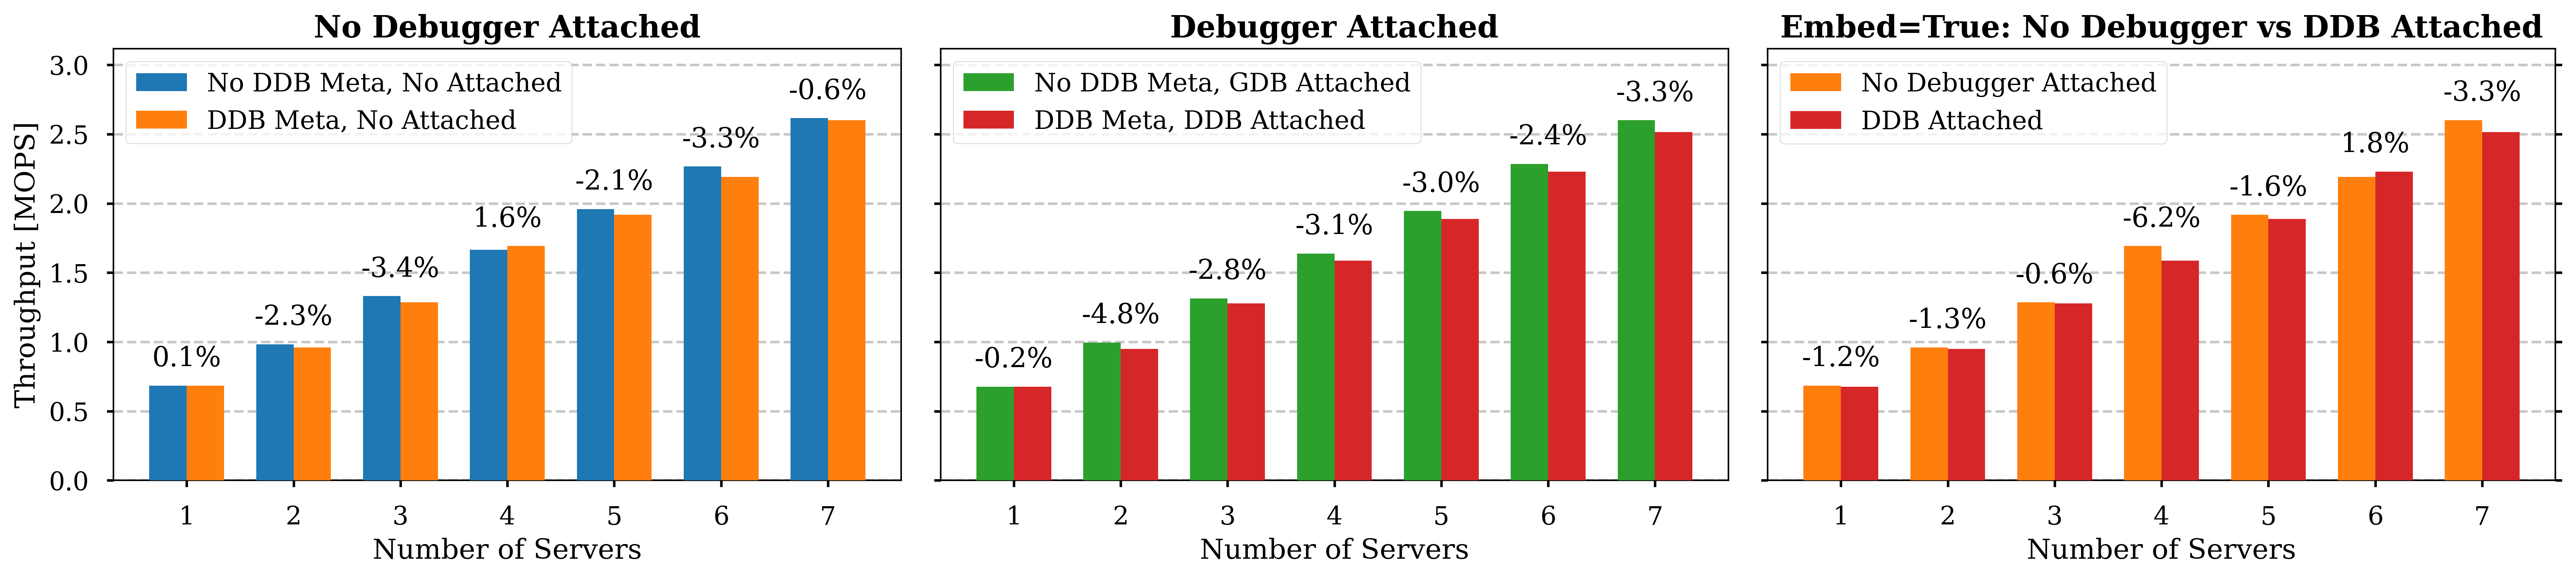

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# # Create a new subplot
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4), sharey=True)

# # Adjust the space between subplots
# plt.subplots_adjust(wspace=0.05)

# Muted colors for the bars
colors = {
    'no_meta_no_attached': '#1f77b4',  # muted blue
    'ddb_meta_no_attached': '#ff7f0e',  # muted orange
    'no_meta_gdb_attached': '#2ca02c',  # muted green
    'ddb_meta_attached': '#d62728',  # muted red
}
# palette = sns.color_palette("muted")
# colors = {
#     'no_meta_no_attached': palette[0],
#     'ddb_meta_no_attached': palette[1],
#     'no_meta_gdb_attached': palette[2],
#     'ddb_meta_attached': palette[3],
# }


# # Plot for embed == False and debugger == "none"
# filtered_df_none = df.query('embed == False and debugger == "none"')
# bars1 = ax1.bar(
#     filtered_df_none['servers'] - bar_width / 2,
#     filtered_df_none['mops'],
#     width=bar_width,
#     label='No DDB Meta, No Attached',
#     zorder=3,
#     color=colors['no_meta_no_attached']
# )

# # Plot for embed == True and debugger == "none"
# filtered_df_gdb = df.query('embed == True and debugger == "none"')
# bars2 = ax1.bar(
#     filtered_df_gdb['servers'] + bar_width / 2,
#     filtered_df_gdb['mops'],
#     width=bar_width,
#     label='DDB Meta, No Attached',
#     zorder=3,
#     color=colors['ddb_meta_no_attached']
# )

# # Annotate percentage difference
# for i in range(len(filtered_df_none)):
#     server = filtered_df_none['servers'].iloc[i]
#     mops_none = filtered_df_none['mops'].iloc[i]
#     mops_gdb = filtered_df_gdb[filtered_df_gdb['servers'] == server]['mops'].values[0]
#     percentage_diff = ((mops_gdb - mops_none) / mops_none) * 100
#     ax1.text(
#         server,
#         max(mops_none, mops_gdb) + 0.1,
#         f'{percentage_diff:.1f}%',
#         ha='center',
#         va='bottom',
#         color='black'
#     )

# # Configure ax1
# ax1.set_xlabel('Number of Servers')
# ax1.set_ylabel('Throughput [MOPS]')
# ax1.set_title('No Debugger Attached', fontweight='bold')
# ax1.legend()
# ax1.grid(axis='y', linestyle='--', alpha=0.7, zorder=0)
# ax1.set_ylim(0, df['mops'].max() + 0.5)

# # Plot for embed == False and debugger == "gdb"
# filtered_df_gdb = df.query('embed == False and debugger == "gdb"')
# bars3 = ax2.bar(
#     filtered_df_gdb['servers'] - bar_width / 2,
#     filtered_df_gdb['mops'],
#     width=bar_width,
#     label='No DDB Meta, GDB Attached',
#     zorder=3,
#     color=colors['no_meta_gdb_attached']
# )

# # Plot for embed == True and debugger == "ddb"
# filtered_df_ddb = df.query('embed == True and debugger == "ddb"')
# bars4 = ax2.bar(
#     filtered_df_ddb['servers'] + bar_width / 2,
#     filtered_df_ddb['mops'],
#     width=bar_width,
#     label='DDB Meta, DDB Attached',
#     zorder=3,
#     color=colors['ddb_meta_attached']
# )

# # Annotate percentage difference
# for i in range(len(filtered_df_gdb)):
#     server = filtered_df_gdb['servers'].iloc[i]
#     mops_gdb = filtered_df_gdb['mops'].iloc[i]
#     mops_ddb = filtered_df_ddb[filtered_df_ddb['servers'] == server]['mops'].values[0]
#     percentage_diff = ((mops_ddb - mops_gdb) / mops_gdb) * 100
#     ax2.text(
#         server,
#         max(mops_gdb, mops_ddb) + 0.1,
#         f'{percentage_diff:.1f}%',
#         ha='center',
#         va='bottom',
#         color='black'
#     )

# # Configure ax2
# ax2.set_xlabel('Number of Servers')
# ax2.set_title('Debugger Attached', fontweight='bold')
# ax2.legend()
# ax2.grid(axis='y', linestyle='--', alpha=0.7, zorder=0)

# Add a shared title and show the plot
# fig.suptitle('MOPS vs Number of Servers: Impact of Debugging Configuration', fontsize=16, fontweight='bold')
# plt.show()




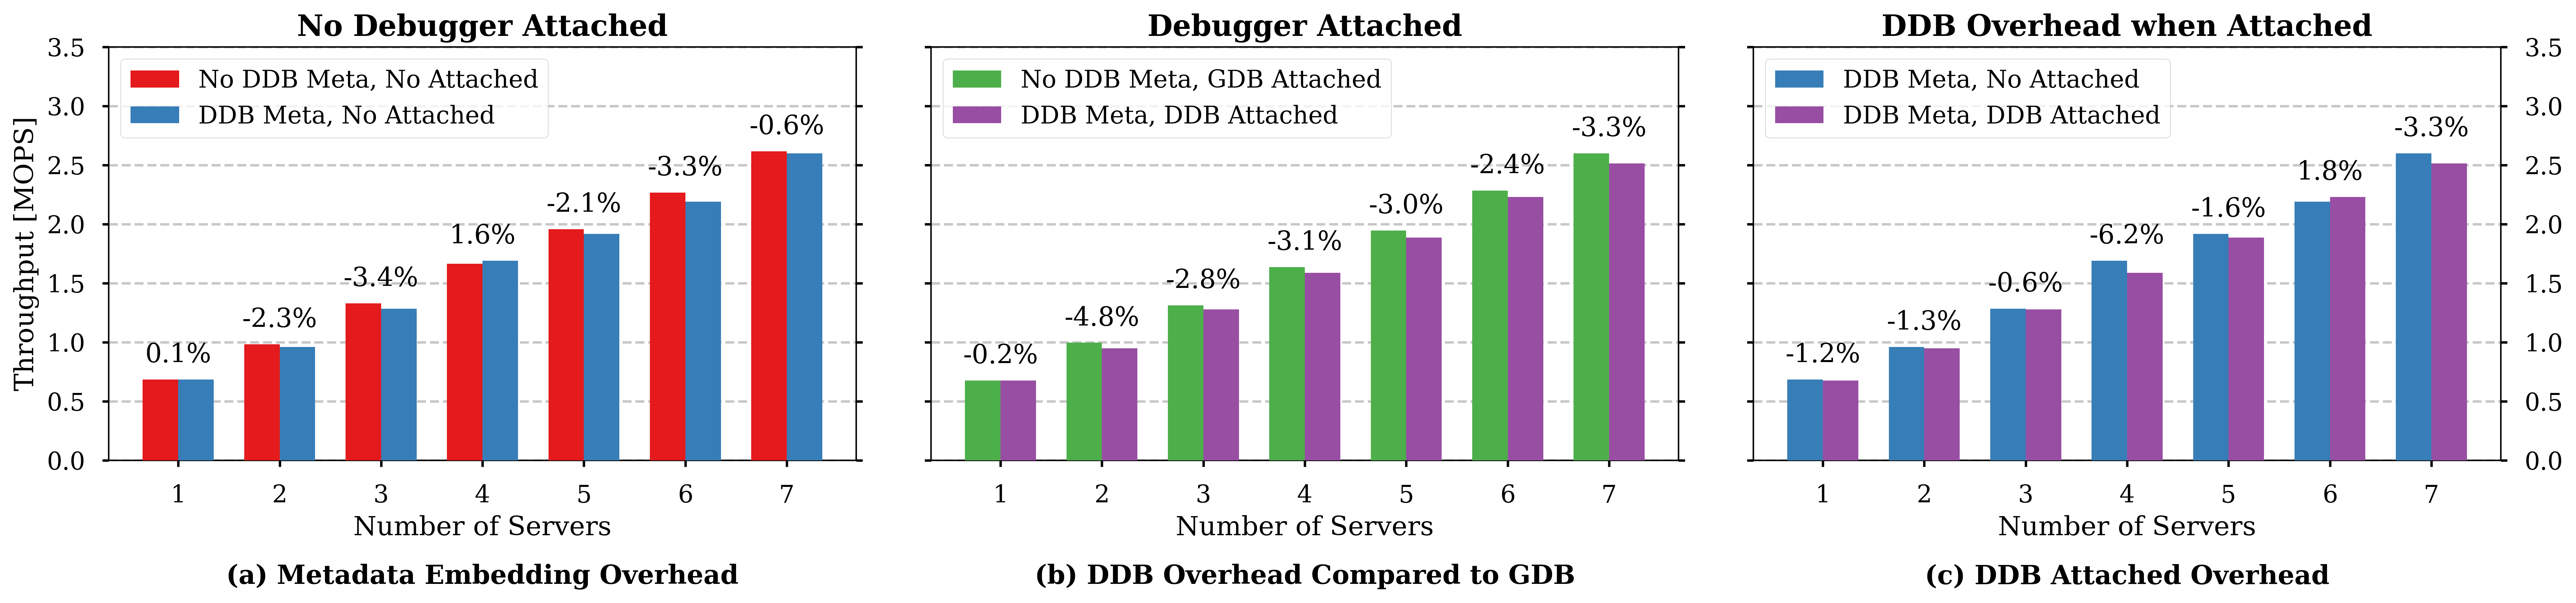

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a new subplot for the comparison
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(23, 4), sharey=True)

palette = sns.color_palette("Set1", 4)
colors = {
    'no_meta_no_attached': palette[0],  # red
    'ddb_meta_no_attached': palette[1],  # blue
    'no_meta_gdb_attached': palette[2],  # green
    'ddb_meta_attached': palette[3],  # purple
}

# Adjust the space between subplots
plt.subplots_adjust(wspace=0.1)

# Plot for embed == False and debugger == "none"
filtered_df_none = df.query('embed == False and debugger == "none"')
bars1 = ax1.bar(
    filtered_df_none['servers'] - bar_width / 2,
    filtered_df_none['mops'],
    width=bar_width,
    label='No DDB Meta, No Attached',
    zorder=3,
    color=colors['no_meta_no_attached']
)

# Plot for embed == True and debugger == "none"
filtered_df_gdb = df.query('embed == True and debugger == "none"')
bars2 = ax1.bar(
    filtered_df_gdb['servers'] + bar_width / 2,
    filtered_df_gdb['mops'],
    width=bar_width,
    label='DDB Meta, No Attached',
    zorder=3,
    color=colors['ddb_meta_no_attached']
)

# Annotate percentage difference
for i in range(len(filtered_df_none)):
    server = filtered_df_none['servers'].iloc[i]
    mops_none = filtered_df_none['mops'].iloc[i]
    mops_gdb = filtered_df_gdb[filtered_df_gdb['servers'] == server]['mops'].values[0]
    percentage_diff = ((mops_gdb - mops_none) / mops_none) * 100
    ax1.text(
        server,
        max(mops_none, mops_gdb) + 0.1,
        f'{percentage_diff:.1f}%',
        ha='center',
        va='bottom',
        color='black'
    )

# Configure ax1
ax1.set_xlabel('Number of Servers')
ax1.set_ylabel('Throughput [MOPS]')
ax1.set_title('No Debugger Attached', fontweight='bold')
ax1.legend()
ax1.yaxis.set_ticks_position('both')
ax1.grid(axis='y', linestyle='--', alpha=0.7, zorder=0)
ax1.set_ylim(0, df['mops'].max() + 0.5)

# Plot for embed == False and debugger == "gdb"
filtered_df_gdb = df.query('embed == False and debugger == "gdb"')
bars3 = ax2.bar(
    filtered_df_gdb['servers'] - bar_width / 2,
    filtered_df_gdb['mops'],
    width=bar_width,
    label='No DDB Meta, GDB Attached',
    zorder=3,
    color=colors['no_meta_gdb_attached']
)

# Plot for embed == True and debugger == "ddb"
filtered_df_ddb = df.query('embed == True and debugger == "ddb"')
bars4 = ax2.bar(
    filtered_df_ddb['servers'] + bar_width / 2,
    filtered_df_ddb['mops'],
    width=bar_width,
    label='DDB Meta, DDB Attached',
    zorder=3,
    color=colors['ddb_meta_attached']
)

# Annotate percentage difference
for i in range(len(filtered_df_gdb)):
    server = filtered_df_gdb['servers'].iloc[i]
    mops_gdb = filtered_df_gdb['mops'].iloc[i]
    mops_ddb = filtered_df_ddb[filtered_df_ddb['servers'] == server]['mops'].values[0]
    percentage_diff = ((mops_ddb - mops_gdb) / mops_gdb) * 100
    ax2.text(
        server,
        max(mops_gdb, mops_ddb) + 0.1,
        f'{percentage_diff:.1f}%',
        ha='center',
        va='bottom',
        color='black'
    )

# Configure ax2
ax2.set_xlabel('Number of Servers')
ax2.set_title('Debugger Attached', fontweight='bold')
ax2.yaxis.set_ticks_position('both')
ax2.legend()
ax2.grid(axis='y', linestyle='--', alpha=0.7, zorder=0)

# Plot for embed == True and debugger == "none"
filtered_df_none_embed = df.query('embed == True and debugger == "none"')
bars5 = ax3.bar(
    filtered_df_none_embed['servers'] - bar_width / 2,
    filtered_df_none_embed['mops'],
    width=bar_width,
    label='DDB Meta, No Attached',
    zorder=3,
    color=colors['ddb_meta_no_attached']
)

# Plot for embed == True and debugger == "ddb"
filtered_df_ddb_embed = df.query('embed == True and debugger == "ddb"')
bars6 = ax3.bar(
    filtered_df_ddb_embed['servers'] + bar_width / 2,
    filtered_df_ddb_embed['mops'],
    width=bar_width,
    label='DDB Meta, DDB Attached',
    zorder=3,
    color=colors['ddb_meta_attached']
)

# Annotate percentage difference
for i in range(len(filtered_df_none_embed)):
    server = filtered_df_none_embed['servers'].iloc[i]
    mops_none_embed = filtered_df_none_embed['mops'].iloc[i]
    mops_ddb_embed = filtered_df_ddb_embed[filtered_df_ddb_embed['servers'] == server]['mops'].values[0]
    percentage_diff = ((mops_ddb_embed - mops_none_embed) / mops_none_embed) * 100
    ax3.text(
        server,
        max(mops_none_embed, mops_ddb_embed) + 0.1,
        f'{percentage_diff:.1f}%',
        ha='center',
        va='bottom',
        color='black'
    )

# Configure ax3
ax3.set_xlabel('Number of Servers')
ax3.set_title('DDB Overhead when Attached', fontweight='bold')
ax3.legend()
ax3.grid(axis='y', linestyle='--', alpha=0.7, zorder=0)

ax3.yaxis.set_ticks_position('both')
ax3.yaxis.set_label_position("right")  # Set the label position for ax3

ax3.yaxis.set_ticks(ax1.get_yticks())  # Synchronize Y-ticks with the first subplot
ax3.tick_params(axis='y', labelright=True)  # Enable right-side labels

# Add a shared title and show the plot
# Add sublabels under each subplot
ax1.text(0.5, -0.25, '(a) Metadata Embedding Overhead', transform=ax1.transAxes, fontweight="bold", va='top', ha='center')
ax2.text(0.5, -0.25, '(b) DDB Overhead Compared to GDB', transform=ax2.transAxes, fontweight="bold", va='top', ha='center')
ax3.text(0.5, -0.25, '(c) DDB Attached Overhead', transform=ax3.transAxes, fontweight="bold", va='top', ha='center')

# fig.suptitle('MOPS vs Number of Servers: Impact of Debugging Configuration', fontsize=16, fontweight='bold')

plt.show()